# WEEK 6 FINAL PROJECT - DISTRACTED DRIVER DETECTION USING CNN

Student, University of Colorado Boulder


## Gather data, determine the method of data collection and provenance of the data 

For the final project, I wanted to work on any object detection/image processing deep learning area.  I found a dataset that could help me with this on Kaggle.

While driving on road, it is not uncommon to see drivers who are distracted.  They may be texting, scrolling through social media, or in a lively hand-held conversation on their phone.  

Quoting from the Kaggle competition: "According to the CDC motor vehicle safety division, one in five car accidents is caused by a distracted driver. Sadly, this translates to 425,000 people injured and 3,000 people killed by distracted driving every year."

The Kaggle challenge was sponsored by State Farm with the intent to better insure their customers, by testing whether dashboard cameras can automatically detect drivers engaging in distracted behaviors. 

The challenge's outcomes are evaluated using the multi-class logarithmic loss. Each image has been labeled with one true class. For each image, we must submit a set of predicted probabilities (one for every image). The formula is then,

$𝑙𝑜𝑔𝑙𝑜𝑠𝑠=\frac{−1}{𝑁}∑_{𝑖=1}^{𝑁}∑_{𝑗=1}^{𝑀}𝑦_{𝑖𝑗}log(𝑝_{𝑖𝑗}),$

where

N is the number of images in the test set, 

M is the number of image class labels,  

\\(log\\) is the natural logarithm, 

\\(y_{ij}\\) is 1 if observation \\(i\\) belongs to class \\(j\\) and 0 otherwise, 

and \\(p_{ij}\\) is the predicted probability that observation \\(i\\) belongs to class \\(j\\).

The submitted probabilities for a given image are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with \\(max(min(p,1-10^{-15}),10^{-15})\\).

To download the data, we have to register for the competion https://www.kaggle.com/competitions/state-farm-distracted-driver-detection/overview

## Identify a Deep Learning Problem

For this project, since the data is from Kaggle, I will be trying different CNN models and comparing their performance.

In [2]:
import os, cv2, random, shutil

import pandas as pd
import numpy as np



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing import image     


from tqdm import tqdm


from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True  
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split


%matplotlib inline

## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

In [56]:

DATA_PATH = "/kaggle"

INPUT_PATH = os.path.join(DATA_PATH, "input/state-farm-distracted-driver-detection")
IMAGES_PATH = os.path.join(INPUT_PATH, "imgs")
TEST_DIR = os.path.join(IMAGES_PATH, "test")
TRAIN_DIR = os.path.join(IMAGES_PATH, "train")

BASE_MODEL_PATH = os.path.join(DATA_PATH, "working", "model")

MODEL_PATH = os.path.join(BASE_MODEL_PATH, "self_trained")
OUTPUT_CSV_FILES_DIR = os.path.join(DATA_PATH, "working", "output_csv_files")
INPUT_CSV_FILES_DIR = os.path.join(DATA_PATH, "working", "input_csv_files")

if not os.path.exists(INPUT_CSV_FILES_DIR):
    os.makedirs(INPUT_CSV_FILES_DIR)
    print(f"Input CSV path created {INPUT_CSV_FILES_DIR}")
    
if not os.path.exists(OUTPUT_CSV_FILES_DIR):
    os.makedirs(OUTPUT_CSV_FILES_DIR)
    print(f"Output CSV path created {OUTPUT_CSV_FILES_DIR}")

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print(f"Model path created {MODEL_PATH}")


In [20]:
train_image = []
image_label = []

img_dim = 64

driver_details = pd.read_csv(os.path.join(INPUT_PATH, "driver_imgs_list.csv"), na_values='na')
driver_details.head(5)

for i in range(10):
    print(f'traversing C{i}')
    imgs = os.listdir(os.path.join(TRAIN_DIR, "c"+str(i)))
    for j in range(len(imgs)):
        img_name = os.path.join(TRAIN_DIR, "c"+str(i), imgs[j])
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(img_dim,img_dim))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

traversing C0
traversing C1
traversing C2
traversing C3
traversing C4
traversing C5
traversing C6
traversing C7
traversing C8
traversing C9


In [65]:
driver_details.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [66]:
driver_details.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_9684.jpg
freq,1237,2489,1


In [68]:
driver_details.isna().sum()

subject      0
classname    0
img          0
dtype: int64

All images seem to be good.  We have no null values in csv.  So, there is nothing to be cleaned

In [21]:
class_value_counts = dict()
for img in train_image:
    class_type = img[1]
    class_value_counts['c'+str(class_type)] = class_value_counts.get('c'+str(class_type), 0)+1

print(class_value_counts)
    

{'c0': 2489, 'c1': 2267, 'c2': 2317, 'c3': 2346, 'c4': 2326, 'c5': 2312, 'c6': 2325, 'c7': 2002, 'c8': 1911, 'c9': 2129}


Let us look at the number of images in each of the different classes

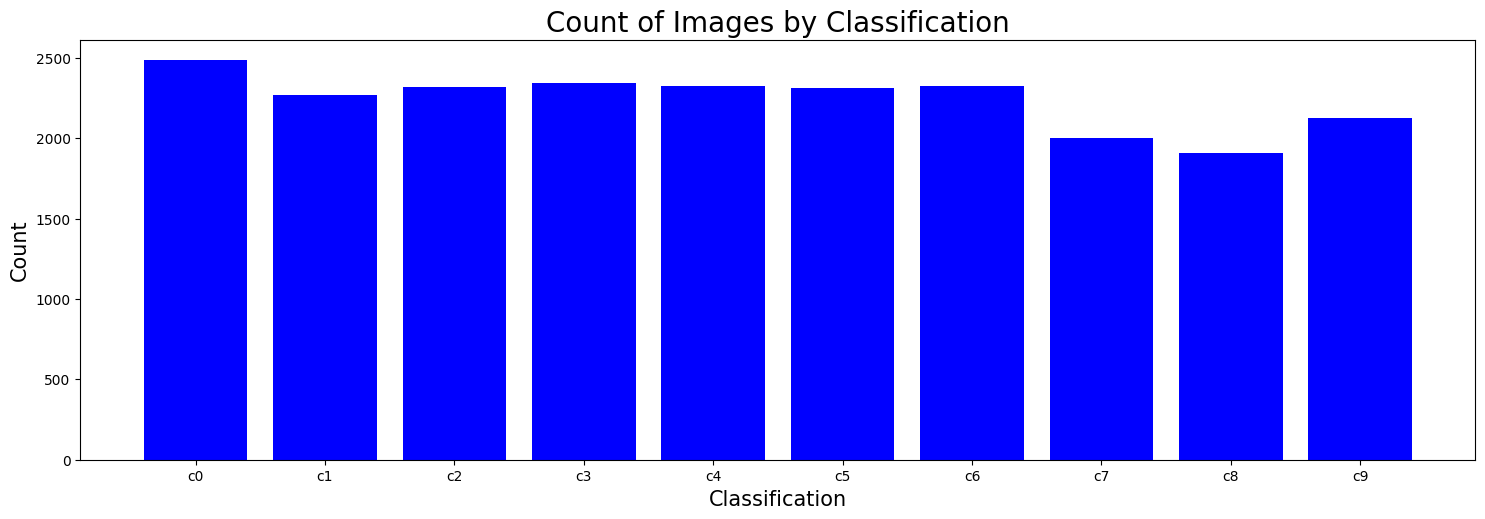

In [22]:
fig = plt.figure(figsize=(18,12))
ay = fig.add_subplot(211)
labels = class_value_counts.keys()
x = range(len(labels))
y = class_value_counts.values()
plt.xticks(x, labels, size=10)
plt.yticks(size=10)

ay.bar(x, y, color="blue")

plt.title('Count of Images by Classification',size=20)
plt.xlabel('Classification', size=15)
plt.ylabel('Count', size=15)

plt.show()

Let us look at one image from each of the different classes

<function matplotlib.pyplot.show(close=None, block=None)>

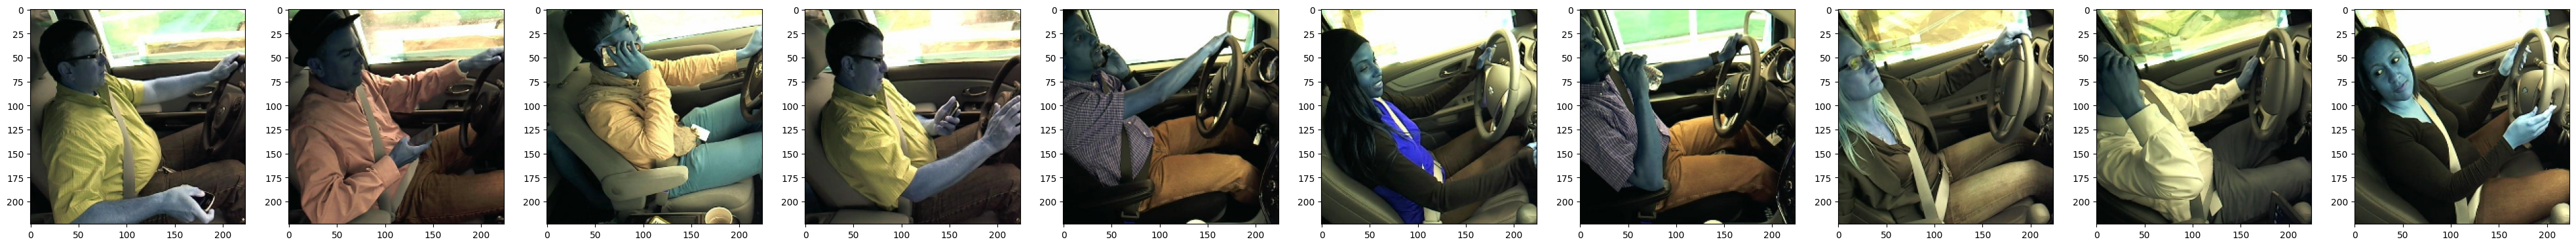

In [60]:
fig, ax = plt.subplots(1, 10, figsize = (50,50 ))
for i in range(10):
    for file in os.listdir(os.path.join(TRAIN_DIR, 'c'+str(i))):
        img = cv2.imread(os.path.join(TRAIN_DIR, 'c'+str(i),file))
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))

        ax[i].imshow(img,cmap = 'gray')
        break
plt.show

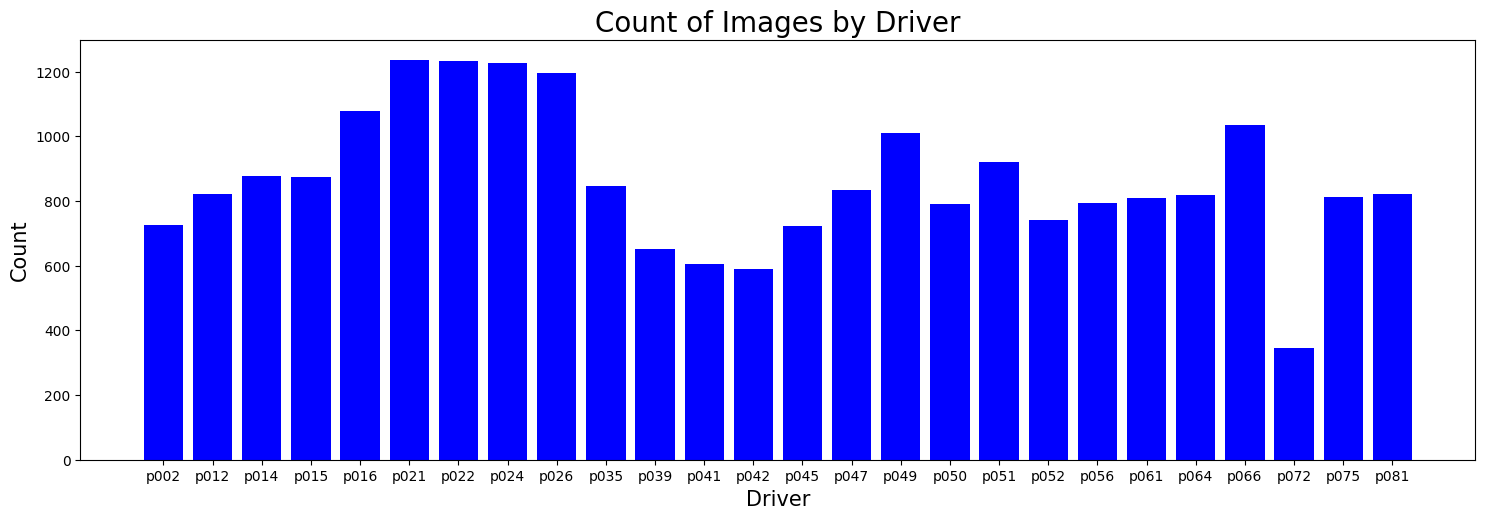

In [74]:
# Find the frequency of images per driver
driver_ids = dict()
for dr in driver_details['subject']:
    driver_ids[dr] = driver_ids.get(dr, 0)+1

d = list()
c = list()
for k,v in driver_ids.items():
    d.append(k)
    c.append(v)

fig = plt.figure(figsize=(18,12))
ay = fig.add_subplot(211)
labels = d
x = range(len(labels))
y = c
plt.xticks(x, labels, size=10)
plt.yticks(size=10)

ay.bar(x, y, color="blue")

plt.title('Count of Images by Driver',size=20)
plt.xlabel('Driver', size=15)
plt.ylabel('Count', size=15)

plt.show()


## Model Building

I will split the data into 80:20 for training and validation.  The CNN model I will start off with is a multi layer one with Conv2D with 64+128+256+512 filters and relu activation, followed by max pooling.  After flattening the data and adding dropouts, finally I will add a softmax layer with 10 classes.

In [32]:
X = list()
y = list()
for features,labels,drivers in train_image:
    X.append(features)
    y.append(labels)
    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))
X_train = np.array(X_train).reshape(-1,img_dim,img_dim,3)
X_test = np.array(X_test).reshape(-1,img_dim,img_dim,3)
print(f'{X_train.shape} {X_test.shape}')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(f'{y_train.shape} {y_test.shape}')

17939 4485
17939 4485
(17939, 64, 64, 3) (4485, 64, 64, 3)
(17939, 10) (4485, 10)


In [33]:
def get_model():
    model = Sequential()
    # 64 conv2d filters with relu
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    # 128 conv2d filters with relu
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    # 256 conv2d filters with relu
    model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    # 512 conv2d filters with relu
    model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
    
    return model

model = get_model()    
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,366 (18.28 MB)

 Trainable params: 4,791,366 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

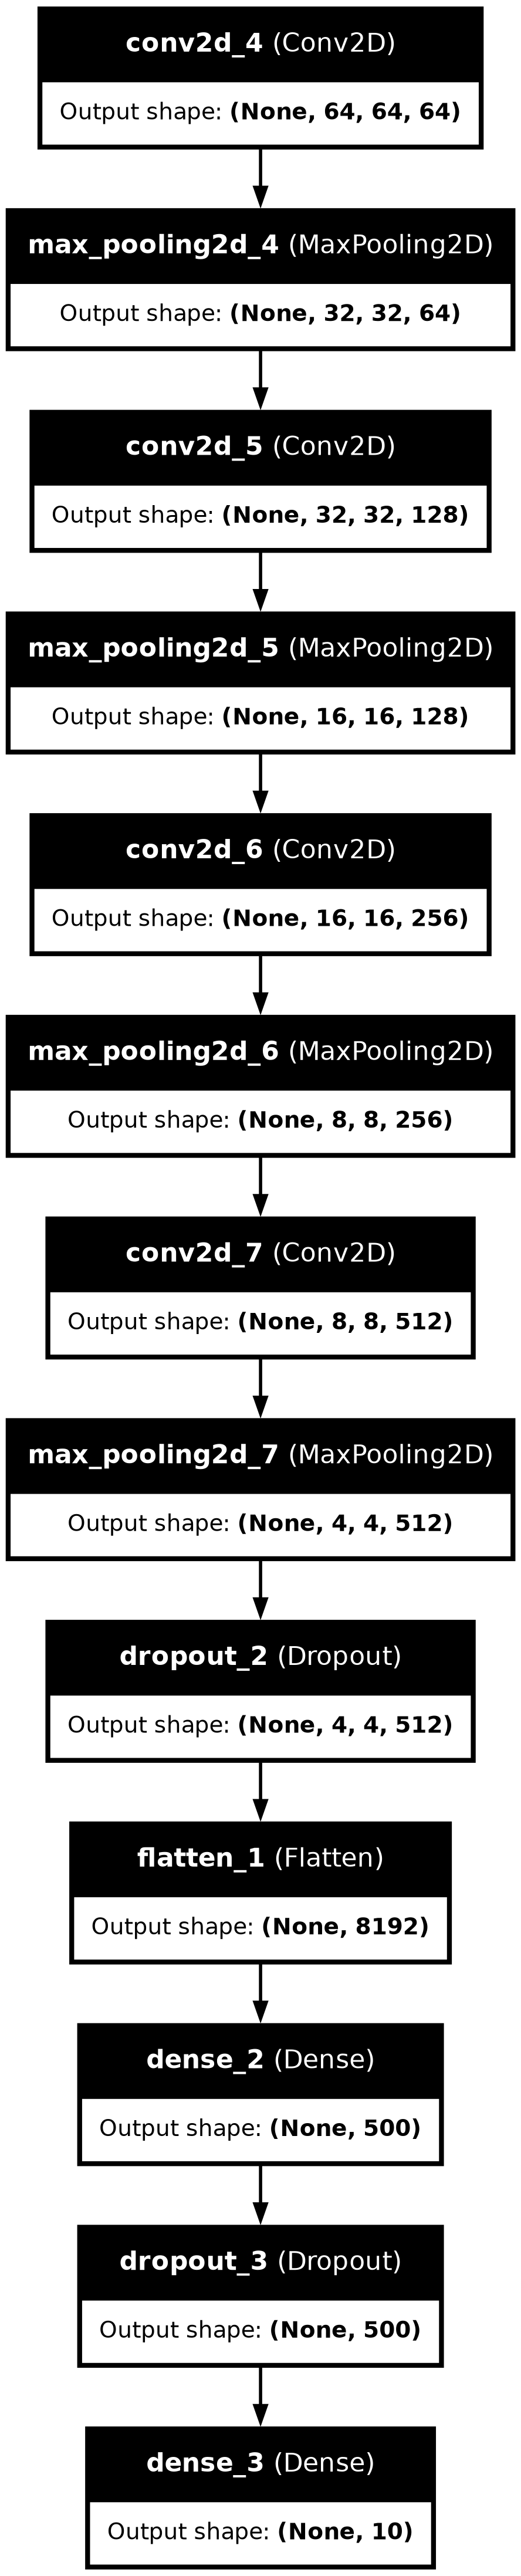

In [34]:
plot_model(model,to_file=os.path.join(MODEL_PATH,"model_distracted_driver.png"),show_shapes=True,show_layer_names=True)

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = os.path.join(MODEL_PATH,"first-{epoch:02d}-{val_accuracy:.2f}.keras")

img_data_gen = ImageDataGenerator(height_shift_range=0.5, width_shift_range=0.5, zoom_range=0.5, rotation_range=30)

data_generator = img_data_gen.flow(X_train, y_train, batch_size=64)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
epochs = 20

model_history = model.fit(data_generator, validation_data=(X_test, y_test), epochs=epochs, batch_size=40, shuffle=True, callbacks=callbacks_list)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/281 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.0703 - loss: 94.4282 

I0000 00:00:1714031376.956743      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714031376.973145      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


118/281 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.1038 - loss: 14.2558

W0000 00:00:1714031391.547976      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.1086 - loss: 8.3521

W0000 00:00:1714031407.352311      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.22965, saving model to /kaggle/working/model/self_trained/first-01-0.23.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 42s 114ms/step - accuracy: 0.1087 - loss: 8.3175 - val_accuracy: 0.2297 - val_loss: 2.1536


W0000 00:00:1714031408.718173      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1476 - loss: 2.2606
Epoch 2: val_accuracy did not improve from 0.22965
281/281 ━━━━━━━━━━━━━━━━━━━━ 25s 88ms/step - accuracy: 0.1477 - loss: 2.2605 - val_accuracy: 0.2161 - val_loss: 2.1655
Epoch 3/20
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1801 - loss: 2.1764
Epoch 3: val_accuracy improved from 0.22965 to 0.30814, saving model to /kaggle/working/model/self_trained/first-03-0.31.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.1802 - loss: 2.1762 - val_accuracy: 0.3081 - val_loss: 1.8722
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2192 - loss: 2.0706
Epoch 4: val_accuracy improved from 0.30814 to 0.41427, saving model to /kaggle/working/model/self_trained/first-04-0.41.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - accuracy: 0.2193 - loss: 2.0706 - val_accuracy: 0.4143 - val_loss: 1.5288
Epoch 5/20
280/281 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2676 - los

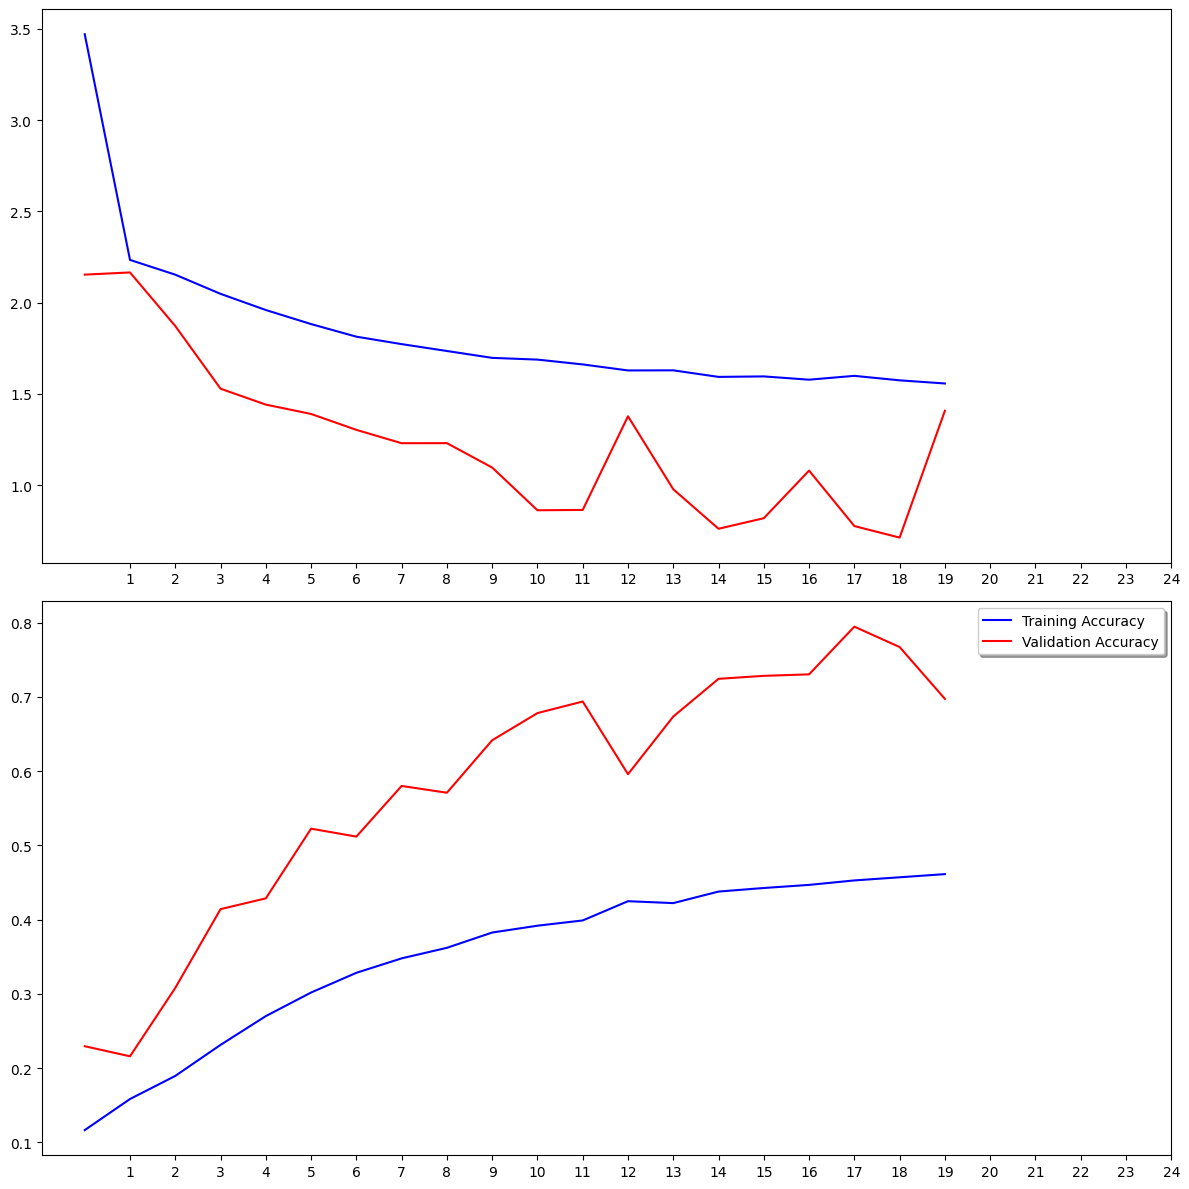

In [38]:
def show_loss_and_accuracy_plots(model_history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    ax1.plot(model_history.history['loss'], color='b', label="Training Loss")
    ax1.plot(model_history.history['val_loss'], color='r', label="Validation Loss")
    ax1.set_xticks(np.arange(1, 25, 1))

    ax2.plot(model_history.history['accuracy'], color='b', label="Training Accuracy")
    ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation Accuracy")
    ax2.set_xticks(np.arange(1, 25, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

show_loss_and_accuracy_plots(model_history)

 66/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1714032332.210508      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


W0000 00:00:1714032332.911818      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


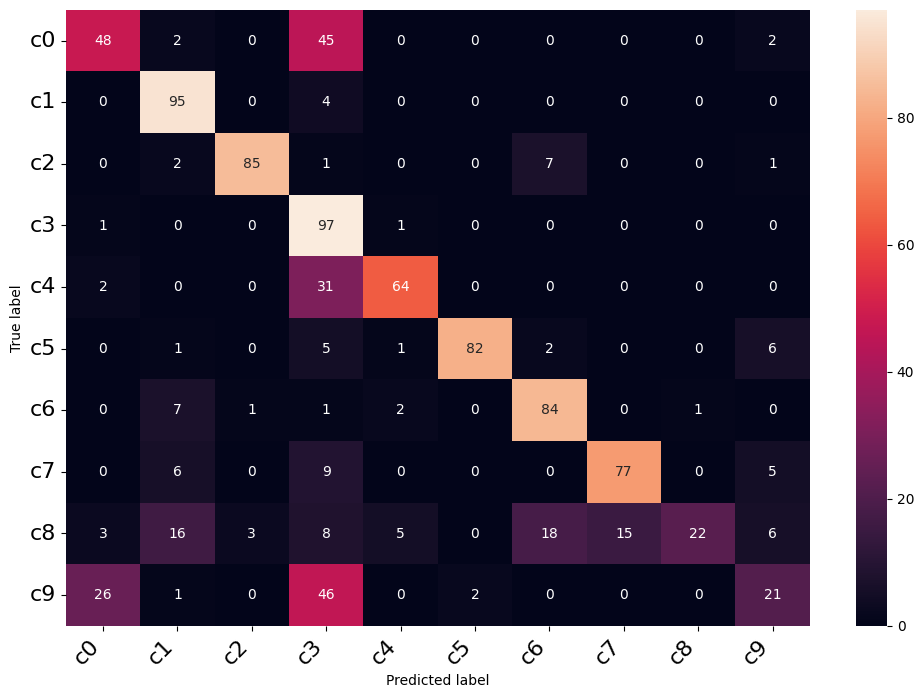

In [39]:
def print_confusion_matrix(confusion_matrix, class_names, figsize=(10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels
    predictions = n_predictions

    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape
    c_m = np.zeros((w, h))
    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]
    c = c_m.astype(dtype = np.uint8)
    heatmap = print_confusion_matrix(c, class_names, figsize=(12,8), fontsize=16)

class_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
y_pred = model.predict(X_test)

print_heatmap(y_test,y_pred,class_names)

In [41]:
y_pred_class = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred_class)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_pred_class, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_pred_class, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_pred_class, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.697436
Precision: 0.744432
Recall: 0.697436
F1 score: 0.683957


In [42]:
#load checkpoint with best val_accuracy
BEST_MODEL = os.path.join(MODEL_PATH,"first-18-0.79.keras") 
model = load_model(BEST_MODEL)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,582,734 (36.56 MB)

 Trainable params: 4,791,366 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,791,368 (18.28 MB)

In [43]:
files = os.listdir(TEST_DIR)
test_images = []
for i in range(len(files)):
    img = cv2.imread(os.path.join(TEST_DIR, files[i]))
    img = img[50:,120:-50]
    img = cv2.resize(img,(64,64))
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,64,64,3)
test_image.shape

NameError: name 'test_image' is not defined

In [44]:
test_images.shape

(79726, 64, 64, 3)

In [47]:
def predict_and_write_results(model, test_images, files, out_file_name):
    df = pd.DataFrame(columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    ypred_test = model.predict(test_images, verbose=1)
    for i in range(len(files)):
        new_row = {
            "img":files[i], 
            'c0':ypred_test[i][0],
            'c1':ypred_test[i][1],
            'c2':ypred_test[i][2],
            'c3':ypred_test[i][3],
            'c4':ypred_test[i][4],
            'c5':ypred_test[i][5],
            'c6':ypred_test[i][6],
            'c7':ypred_test[i][7],
            'c8':ypred_test[i][8],
            'c9':ypred_test[i][9]
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_csv(os.path.join(OUTPUT_CSV_FILES_DIR,out_file_name),index=False)

predict_and_write_results(model, test_images, files, 'kaggle_self_trained_first_model.csv')

2492/2492 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


/tmp/ipykernel_34/950582733.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


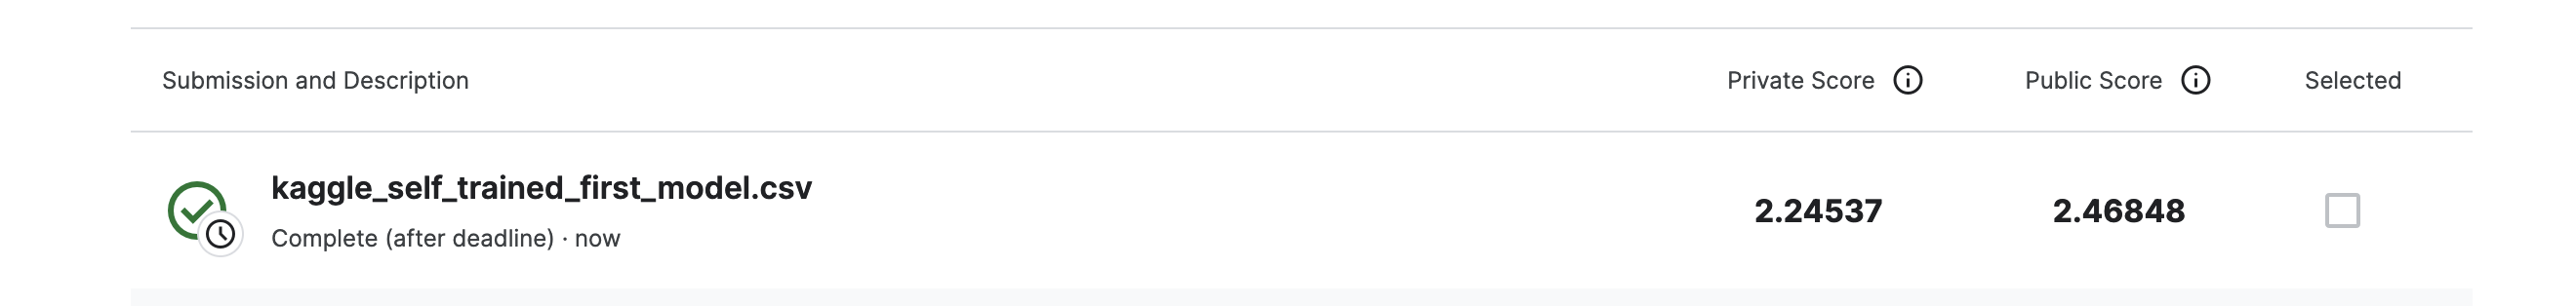

## Tuning training process

This score is good.  However, when the images are split randomly, different images of the same person will end up in training and validation and there appears to be a leak in the model.  Let us try if the same model will work better if we split our training data according to driver instead of random split


In [48]:
driv_selected = ['p050', 'p015', 'p022', 'p056']
## Split the data into training and validation

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [49]:
X_train = np.array(X_train).reshape(-1,img_dim,img_dim,3)
X_test = np.array(X_test).reshape(-1,img_dim,img_dim,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)

(18732, 64, 64, 3)


In [50]:
model = get_model()    
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,366 (18.28 MB)

 Trainable params: 4,791,366 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = os.path.join(MODEL_PATH,"second-{epoch:02d}-{val_accuracy:.2f}.keras")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


img_data_gen = ImageDataGenerator(height_shift_range=0.5, width_shift_range = 0.5, zoom_range = 0.5, rotation_range=30)

data_generator = img_data_gen.flow(X_train, y_train, batch_size=64)

history = model.fit(data_generator, callbacks=callbacks_list, epochs=20, verbose=1, validation_data=(X_test, y_test), batch_size=40, shuffle=True)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/293 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.0972 - loss: 76.3583

W0000 00:00:1714037371.592966      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


124/293 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.0970 - loss: 11.9435

W0000 00:00:1714037387.950956      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.1049 - loss: 7.2001

W0000 00:00:1714037403.532477      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.18743, saving model to /kaggle/working/model/self_trained/second-01-0.19.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step - accuracy: 0.1049 - loss: 7.1867 - val_accuracy: 0.1874 - val_loss: 2.1930
Epoch 2/20


W0000 00:00:1714037404.999101      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1452 - loss: 2.2601
Epoch 2: val_accuracy did not improve from 0.18743
293/293 ━━━━━━━━━━━━━━━━━━━━ 26s 87ms/step - accuracy: 0.1452 - loss: 2.2600 - val_accuracy: 0.1603 - val_loss: 2.6819
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.1961 - loss: 2.1519
Epoch 3: val_accuracy improved from 0.18743 to 0.32990, saving model to /kaggle/working/model/self_trained/second-03-0.33.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 26s 88ms/step - accuracy: 0.1961 - loss: 2.1518 - val_accuracy: 0.3299 - val_loss: 1.8668
Epoch 4/20
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2519 - loss: 2.0038
Epoch 4: val_accuracy improved from 0.32990 to 0.36809, saving model to /kaggle/working/model/self_trained/second-04-0.37.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.2520 - loss: 2.0037 - val_accuracy: 0.3681 - val_loss: 1.8019
Epoch 5/20
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2955 - loss: 1.9057

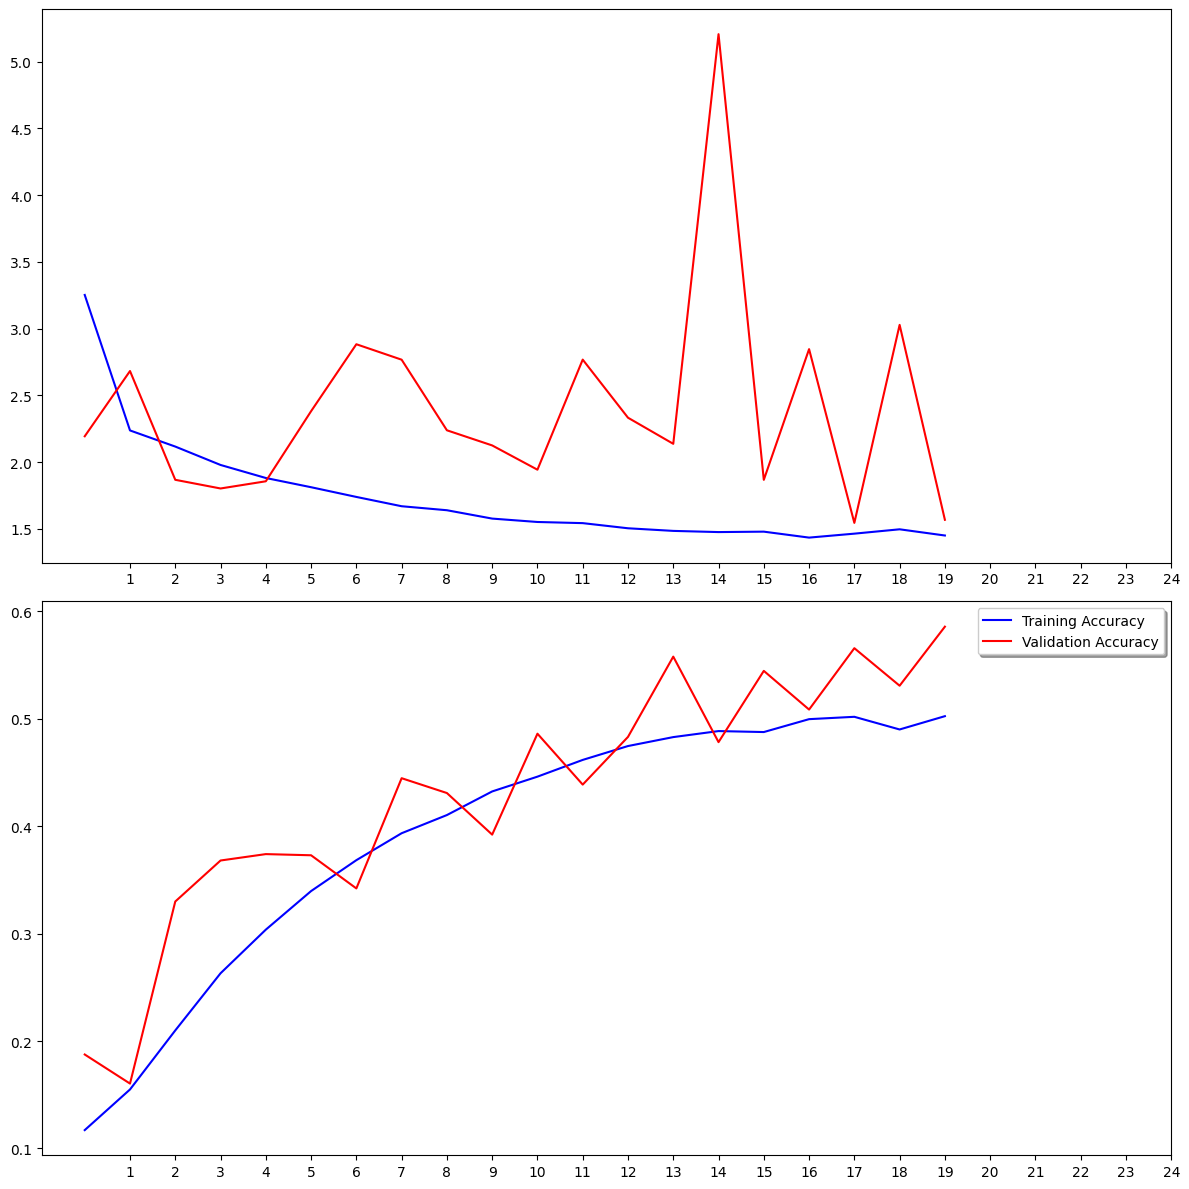

In [53]:
show_loss_and_accuracy_plots(history)

In [52]:
#load checkpoint with best val_accuracy
BEST_MODEL = os.path.join(MODEL_PATH,"second-20-0.59.keras") 
model = load_model(BEST_MODEL)
model.summary()
predict_and_write_results(model, test_images, files, 'kaggle_self_trained_second_model.csv')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │     4,096,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,582,734 (36.56 MB)

 Trainable params: 4,791,366 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,791,368 (18.28 MB)

  42/2492 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step 

W0000 00:00:1714038070.214186      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2492/2492 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


W0000 00:00:1714038076.708742      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/tmp/ipykernel_34/950582733.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


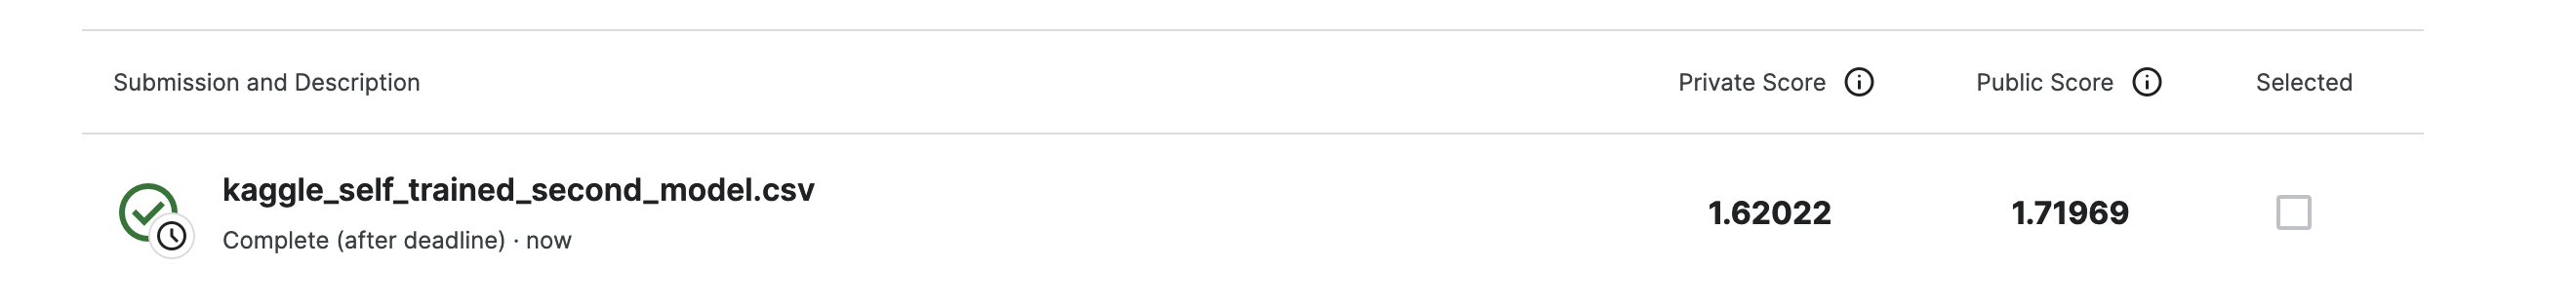

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


W0000 00:00:1714041371.230180      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


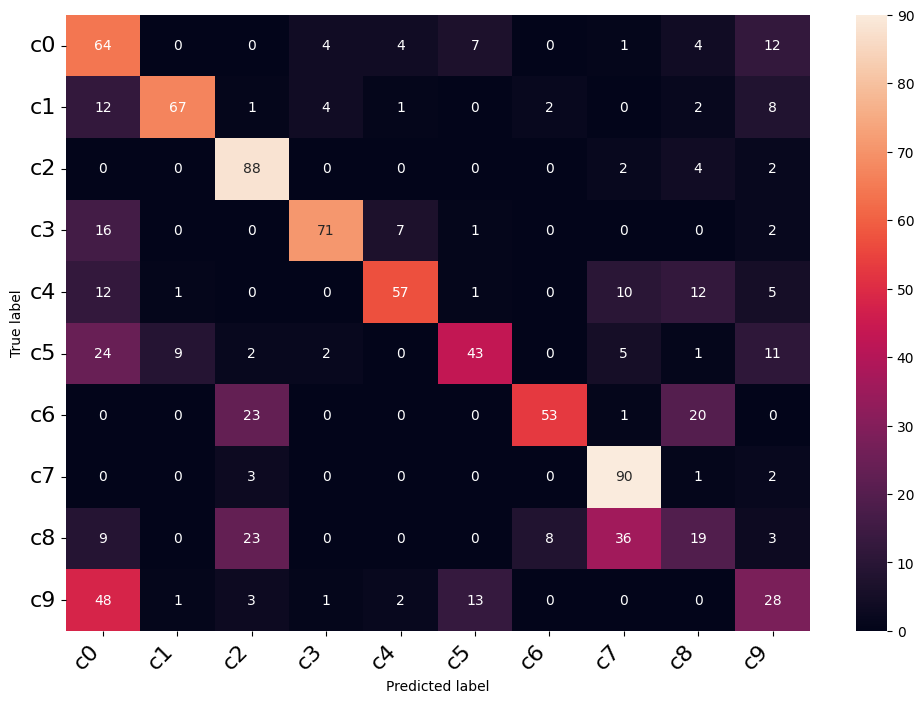

In [54]:
y_pred = model.predict(X_test)

print_heatmap(y_test,y_pred,class_names)

In [55]:
y_pred_class = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test, y_pred_class)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_pred_class, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_pred_class, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_pred_class, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.585861
Precision: 0.618950
Recall: 0.585861
F1 score: 0.582167


The same model performed better when training data is split according to driver instead of random split.  A comparision between the two models is given below

|     | accuracy|loss|val_accuracy |val_loss|Kaggle Private Score|Kaggle Public Score|
| -------- | ------- |------- |------- |------- |------- |------- |
| Model 1  | 0.4512 | 1.6058 | 0.7946 | 0.7764 | 2.24537|2.46848|
| Model 2  | 0.4960 | 1.4666 | 0.5859 | 1.5672 | 1.62022|1.71969|

## Hyperparameter Tuning

I will add a new layer with 1024 filters and use Adam optimizer to see how this model performs

In [63]:
def get_new_model():
    model = Sequential()
    # 64 conv2d filters with relu
    model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64,64,3), kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    # 128 conv2d filters with relu
    model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    # 256 conv2d filters with relu
    model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    # 512 conv2d filters with relu
    model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    # 1024 conv2d filters with relu
    model.add(Conv2D(filters=1024, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
    return model

driv_selected = ['p050', 'p015', 'p022', 'p056']
## Split the data into training and validation

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
        
X_train = np.array(X_train).reshape(-1,img_dim,img_dim,3)
X_test = np.array(X_test).reshape(-1,img_dim,img_dim,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model = get_new_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = os.path.join(MODEL_PATH,"third-{epoch:02d}-{val_accuracy:.2f}.keras")

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


img_data_gen = ImageDataGenerator(height_shift_range=0.5, width_shift_range=0.5, zoom_range=0.5, rotation_range=30)

data_generator = img_data_gen.flow(X_train, y_train, batch_size=64)

history = model.fit(data_generator, callbacks=callbacks_list, epochs=20, verbose=1, validation_data=(X_test, y_test), batch_size=40, shuffle=True)


Epoch 1/20
  3/293 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.0920 - loss: 37.1295

W0000 00:00:1714042736.664572      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/293 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.0994 - loss: 6.1566 

W0000 00:00:1714042757.530636      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1044 - loss: 5.1429 

W0000 00:00:1714042767.041167      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.21560, saving model to /kaggle/working/model/self_trained/third-01-0.22.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.1045 - loss: 5.1273 - val_accuracy: 0.2156 - val_loss: 2.1515
Epoch 2/20


W0000 00:00:1714042768.259210      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.1725 - loss: 2.1766
Epoch 2: val_accuracy improved from 0.21560 to 0.31717, saving model to /kaggle/working/model/self_trained/third-02-0.32.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.1726 - loss: 2.1762 - val_accuracy: 0.3172 - val_loss: 1.9443
Epoch 3/20
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2603 - loss: 1.9625
Epoch 3: val_accuracy improved from 0.31717 to 0.38164, saving model to /kaggle/working/model/self_trained/third-03-0.38.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 27s 90ms/step - accuracy: 0.2604 - loss: 1.9622 - val_accuracy: 0.3816 - val_loss: 1.6303
Epoch 4/20
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3241 - loss: 1.7817
Epoch 4: val_accuracy improved from 0.38164 to 0.38218, saving model to /kaggle/working/model/self_trained/third-04-0.38.keras
293/293 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.3242 - loss: 1.7816 - val_accuracy: 0.3822 - val_loss: 2.0792
Epoch 5/20
2

In [64]:
#load checkpoint with best val_accuracy
BEST_MODEL = os.path.join(MODEL_PATH,"third-17-0.66.keras") 
model = load_model(BEST_MODEL)
model.summary()
predict_and_write_results(model, test_images, files, 'kaggle_self_trained_third_model.csv')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 512)      │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 1024)     │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 500)            │     2,048,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,524,628 (55.41 MB)

 Trainable params: 4,841,542 (18.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,683,086 (36.94 MB)

  54/2492 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step 

W0000 00:00:1714043305.647168      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2492/2492 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


W0000 00:00:1714043314.027145      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/tmp/ipykernel_34/950582733.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


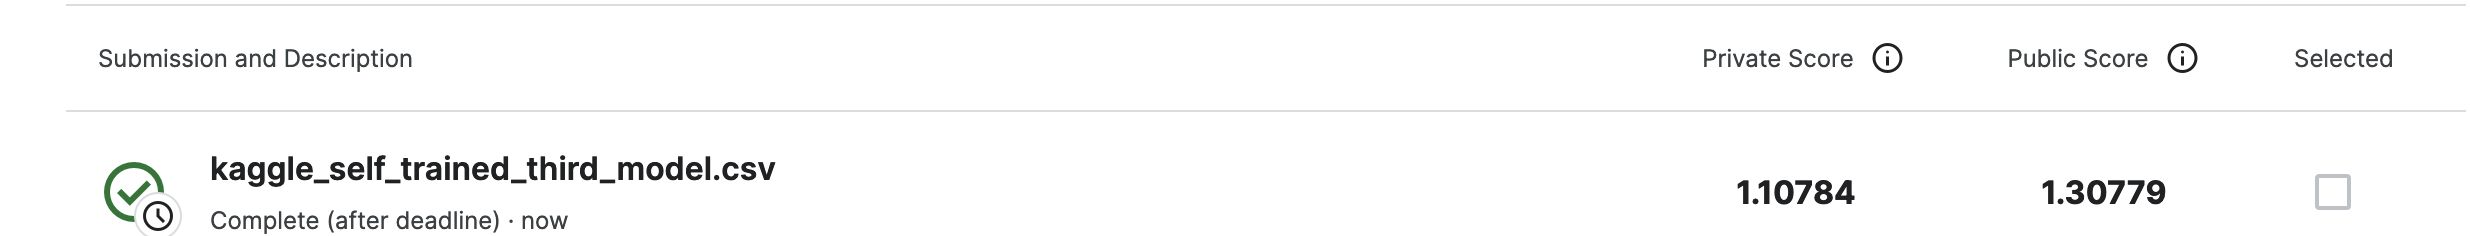

This model performed better than the last 2 models after the hyper parameter tuning

|     | accuracy|loss|val_accuracy |val_loss|Kaggle Private Score|Kaggle Public Score|
| -------- | ------- |------- |------- |------- |------- |------- |
| Model 1  | 0.4512 | 1.6058 | 0.7946 | 0.7764 | 2.24537|2.46848|
| Model 2  | 0.4960 | 1.4666 | 0.5859 | 1.5672 | 1.62022|1.71969|
| Model 3  | 0.6715 | 0.9381| 0.6579 | 1.2424 | 1.10784|1.30779|

## Results Comparision

Apart from the self trained models, I have tried transfer learning using Mobilenet and Resnet models.  I am not adding those details in this notebook file since it will increase the size of this notebook.

The corresponding Jupyter notebooks are available on github: https://github.com/krishnakuruvadi/5511_Final

Comparision between the best models is given below


|     | accuracy|loss|val_accuracy |val_loss|Kaggle Private Score|Kaggle Public Score|
| -------- | ------- |------- |------- |------- |------- |------- |
| Self trained  | 0.6715 | 0.9381| 0.6579 | 1.2424 | 1.10784|1.30779|
| Mobilenet | 0.8816 | 0.3670 | 0.8621 | 0.4850|0.41831|0.60318|
| Resnet| 0.7843 | 0.6402 | 0.8602 | 0.4452|0.41789|0.52613|

## Findings From Results

Mobilenet and Resnet achieved almost same results and the results are better then the self trained model.  When we compare the self trained models with these pre-trained models, we see the number of layers and parameters are more.  Also the weights in the pre-trained models are set based on a lot of training data. 

## Conclusion
* Pre-trained models work well for such usecase when compared to a general self trained model
* We could take the pre-trained models and add more layers or use the pre-trained models as reference to come up with a better self trained model
* Training takes more time and without GPUs working on this kind of tasks is very time consuming

What I would like to try:

* I would try to use other recent image processing pre-trained models like YOLO
* Fine tune the hyper parameters further
* Change image size/resolution to 224 instead of 64

## Deliverables

Github: https://github.com/krishnakuruvadi/5511_Final

Presentation: https://github.com/krishnakuruvadi/5511_Final

Kaggle scores of all models tried (including the ones not available on github):
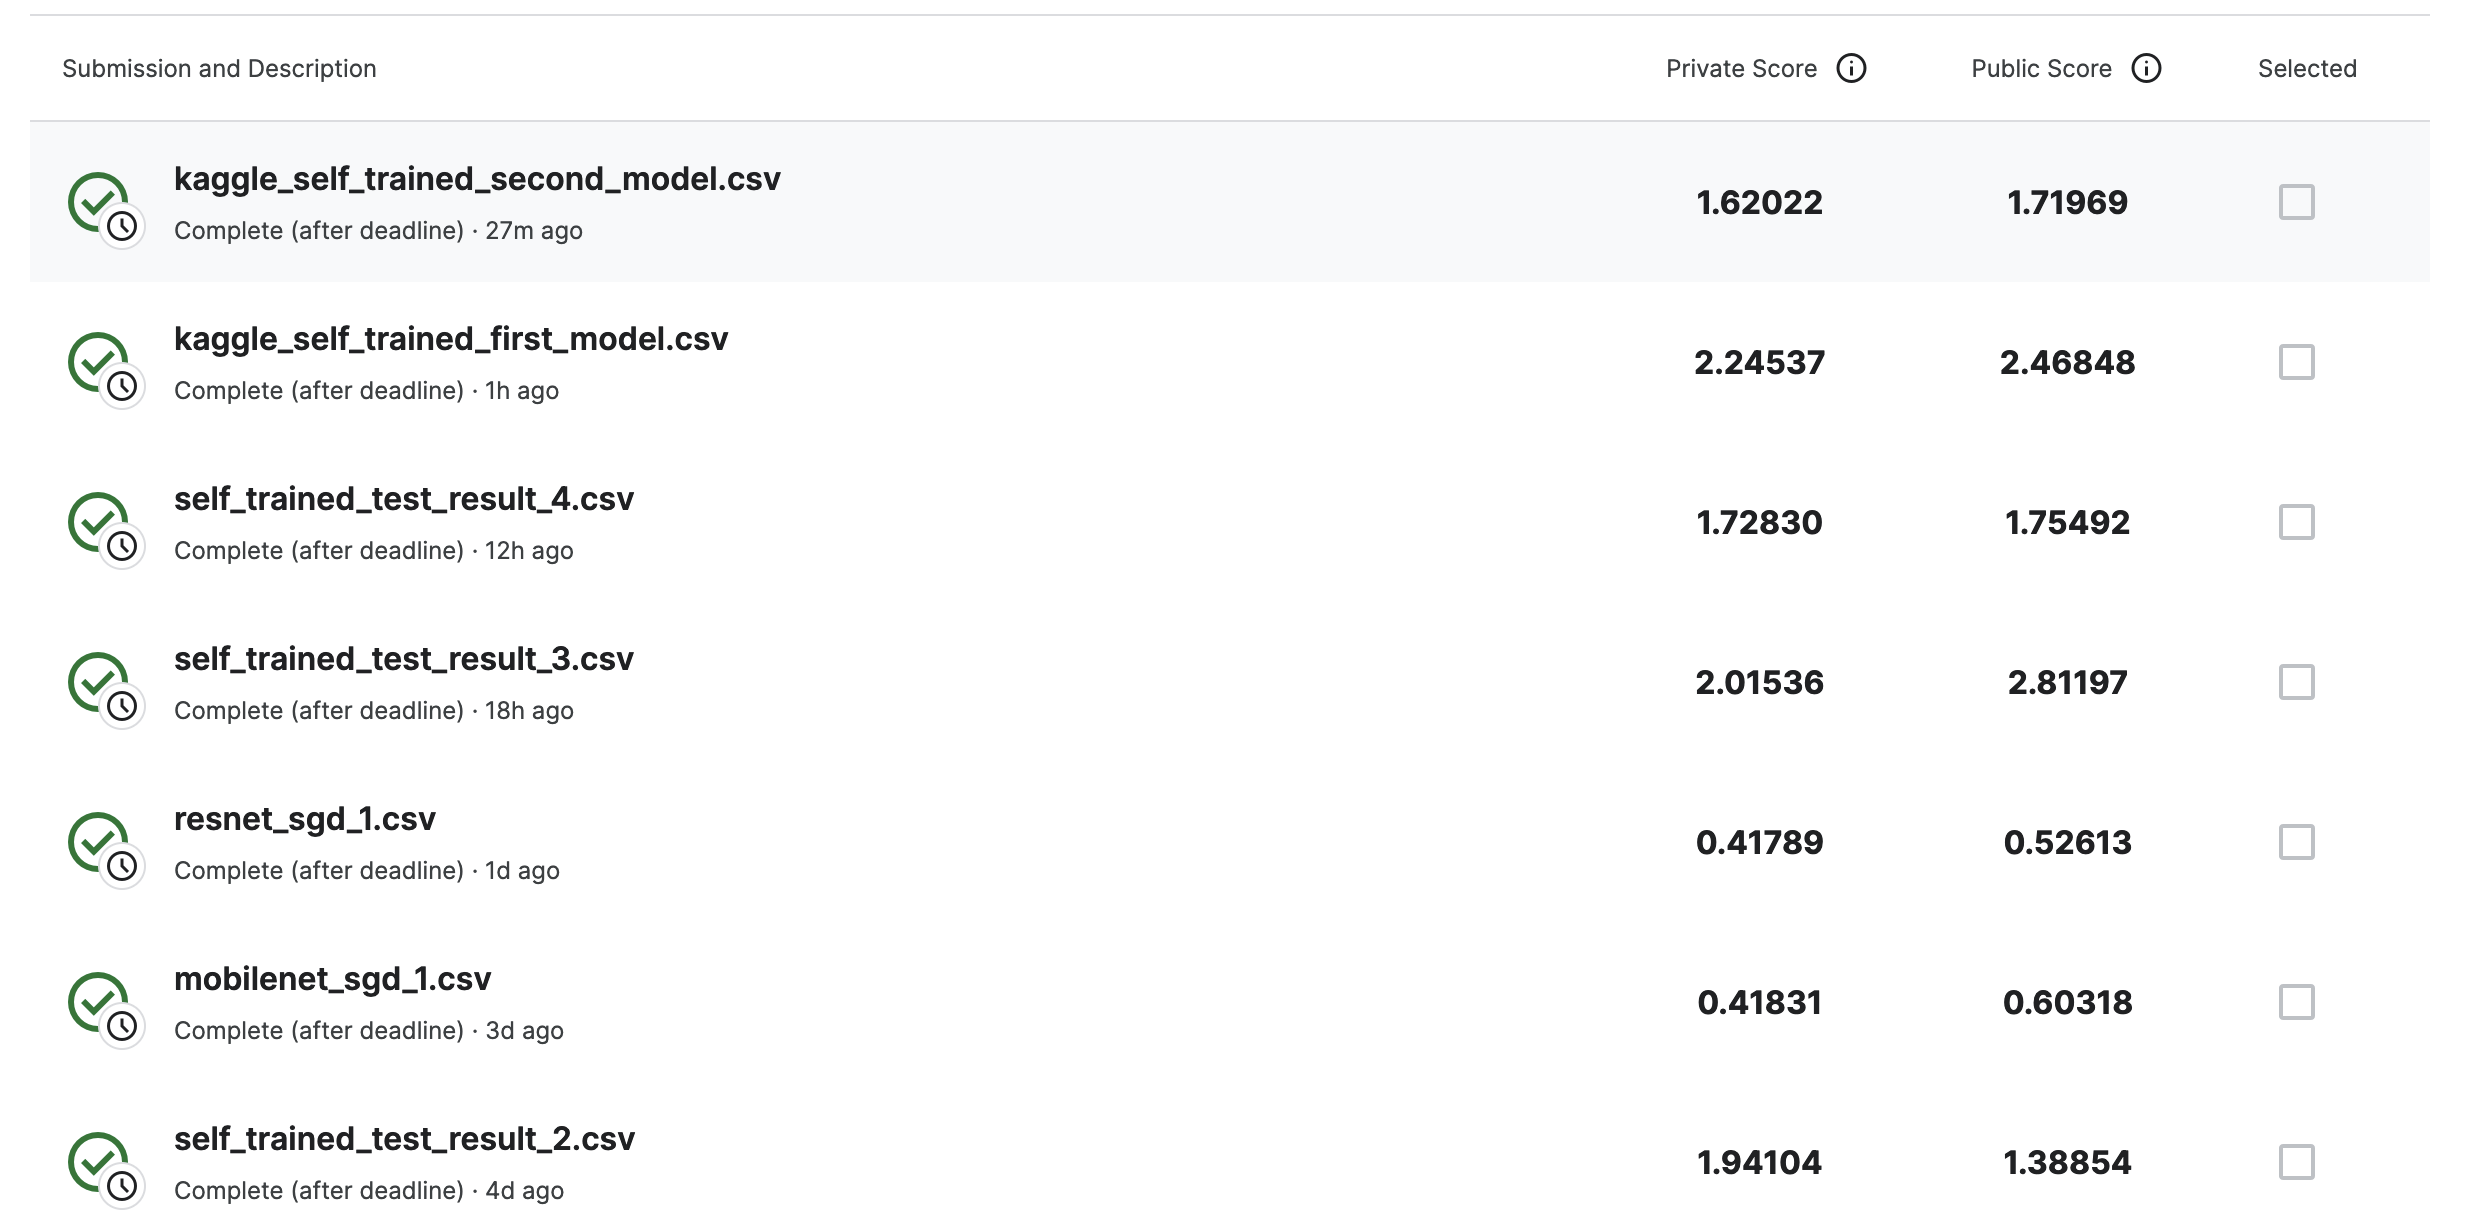

Probable leaderboard place based on best model results (Resnet) is ~271/1439:
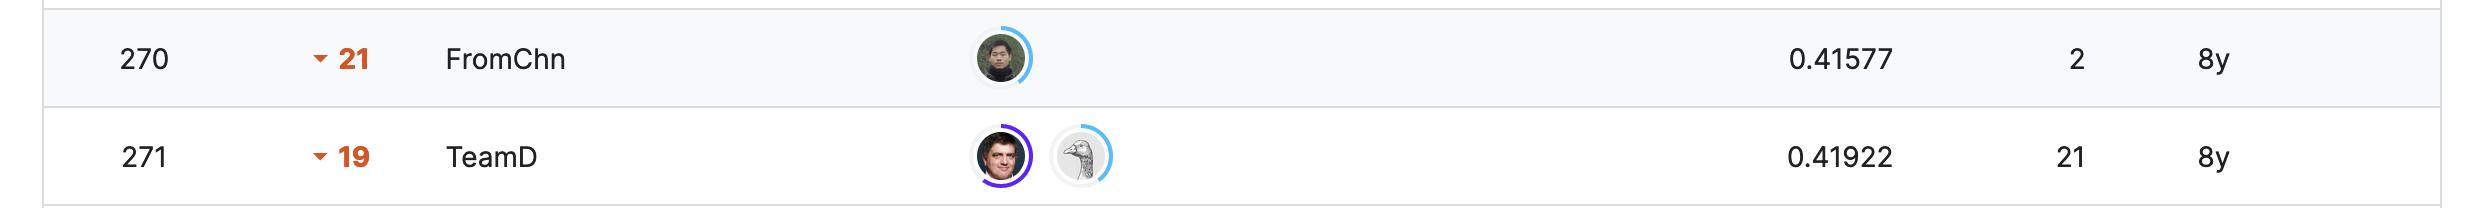

## References
* RESNET: https://en.wikipedia.org/wiki/Residual_neural_network
* Mobilenet: https://keras.io/api/applications/mobilenet/
* State Farm Kaggle competition: https://www.kaggle.com/competitions/state-farm-distracted-driver-detection
